In [1]:
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
import time


import keras
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import img_to_array,load_img
from keras.applications import VGG16
from keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.utils import np_utils, to_categorical
from sklearn.datasets import load_files
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
#The path of our data on drive
data_dir =  r'E:\coviddataset1\COVID-19_Dataset\dataset'
 
#Loading Data
data = load_files(data_dir)

In [3]:
folders=os.listdir("E:\coviddataset1\COVID-19_Dataset\dataset")
print(folders)

['covid_images', 'normal_images', 'viral_images']


In [4]:
#Convert the data and labels to Numpy arrays
X = np.array(data['filenames'])
y = np.array(data['target'])
labels = np.array(data['target_names'])
 
# How the arrays look like?
print('Data files - ',X[0])
print('Target labels - ',y[0])
print('Number of training files : ', X.shape[0])
print('Number of training targets : ', y.shape[0])

Data files -  E:\coviddataset1\COVID-19_Dataset\dataset\normal_images\Normal-5551.png
Target labels -  1
Number of training files :  12315
Number of training targets :  12315




- X - filenames (Training data)
- y - image names(Target labels)

In [5]:
def convert_img_to_arr(file_path_list):
    arr = []
    img_width, img_height = 100,100 
    #Loop over the image paths
    for file_path in file_path_list:
        """
           Load the image, swap color channels, and resize it to be a fixed
           150*150 pixels while ignoring aspect ratio
        """
        img = load_img(file_path, target_size = (img_width, img_height))
        img = img_to_array(img)
        
        #update the data
        arr.append(img)
    return arr
# Here our data is updated and it's stocked in the X array again !
X = np.array(convert_img_to_arr(X))

# The Data Shape
print(X.shape) 
print('First training item : ',X[0])

(12315, 100, 100, 3)
First training item :  [[[104. 104. 104.]
  [ 74.  74.  74.]
  [ 58.  58.  58.]
  ...
  [142. 142. 142.]
  [150. 150. 150.]
  [159. 159. 159.]]

 [[  0.   0.   0.]
  [  0.   0.   0.]
  [  0.   0.   0.]
  ...
  [ 74.  74.  74.]
  [ 82.  82.  82.]
  [100. 100. 100.]]

 [[  0.   0.   0.]
  [  0.   0.   0.]
  [  0.   0.   0.]
  ...
  [  0.   0.   0.]
  [  0.   0.   0.]
  [  0.   0.   0.]]

 ...

 [[  2.   2.   2.]
  [  1.   1.   1.]
  [  0.   0.   0.]
  ...
  [  0.   0.   0.]
  [  1.   1.   1.]
  [  3.   3.   3.]]

 [[  2.   2.   2.]
  [  2.   2.   2.]
  [  0.   0.   0.]
  ...
  [  0.   0.   0.]
  [  1.   1.   1.]
  [  3.   3.   3.]]

 [[  2.   2.   2.]
  [  2.   2.   2.]
  [  0.   0.   0.]
  ...
  [  0.   0.   0.]
  [  1.   1.   1.]
  [  3.   3.   3.]]]



#### Note that the shape of training data is **(12315, 100, 100, 3)**
#####  
 
-   **12315** is the **number** of training items or files,
-   **(100,100)** is the **target size** or image size provided while loading image
-   **3** refers to the **depth** for colored images ( RGB channels ).

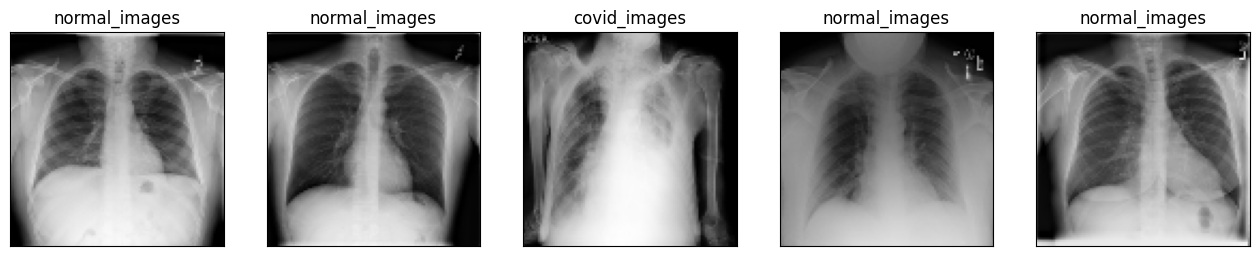

In [6]:
#Let's look at first 5 training data. 
fig = plt.figure(figsize = (16,9))
for i in range(5):
    ax = fig.add_subplot(1,5,i+1,xticks=[],yticks=[])
    ax.imshow((X[i].astype(np.uint8)))
    plt.title(folders[y[i]])

> **rescale value** is a value by which we will multiply the data before any other processing. Our original images consist in RGB coefficients in the 0-255, but such values would be too high for our models to process (given a typical learning rate), so we target values between 0 and 1 instead by scaling with a 1/255. factor. So all values in X will lie within 0 to 1 !

In [7]:
"""
   data is converted into Numpy array, Now, 
   Let's scale the pixel intenties to the range[0,255]
"""
X = X.astype('float32')/255

# Let's confirm the number of classes :) 
no_of_classes = len(np.unique(y))
no_of_classes

3

In [8]:
y

array([1, 1, 0, ..., 1, 1, 0])

In [9]:
""" 
let's converts a class vector (integers) to binary class matrix by performing the 
one-hot encoding on the labels
"""
y = np.array(np_utils.to_categorical(y,no_of_classes))
y[0]

array([0., 1., 0.], dtype=float32)


> Here we are going to split our dataset into **80% train**, **10% validation**, and **10% test**.

In [10]:
# let's splite the data into subsets and explore their shapes !

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
print('The train Data Shape ', X_train.shape[0])
 
X_test, X_valid, y_test, y_valid = train_test_split(X_test,y_test, test_size = 0.5)
print('The validation Data Shape ', X_valid.shape[0])
print('The test Data Shape ', X_test.shape[0])

The train Data Shape  9852
The validation Data Shape  1232
The test Data Shape  1231


In [11]:
print('The train Data Shape ', X_train.shape[1:])

The train Data Shape  (100, 100, 3)


### **CNN Implementation**

#### Here we will build our own architecture as shown in the image below.
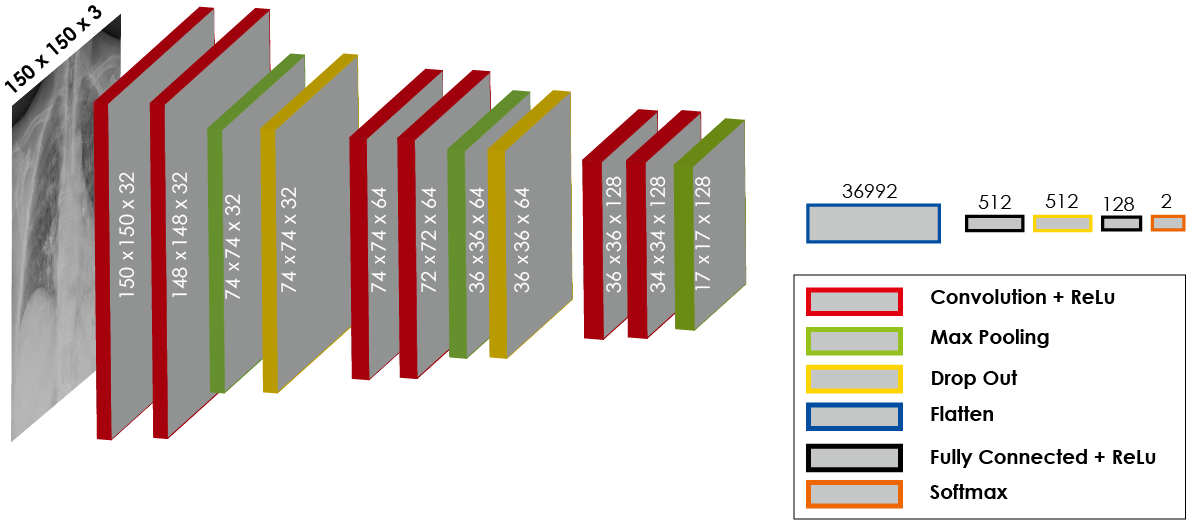

In [12]:
# Required libraries
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

In [13]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', input_shape=X_train.shape[1:], activation='relu', name='Conv2D_1'))
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', name='Conv2D_2'))
model.add(MaxPool2D(pool_size=(2,2), name='Maxpool_1'))
# model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', name='Conv2D_3'))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', name='Conv2D_4'))
model.add(MaxPool2D(pool_size=(2,2), name='Maxpool_2'))
model.add(Dropout(0.25))
    
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', name='Conv2D_5'))
model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', name='Conv2D_6'))
model.add(MaxPool2D(pool_size=(2,2), name='Maxpool_3'))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(units=1024, activation='relu', name='Dense_1'))

model.add(Dense(units=256, activation='relu', name='Dense_2'))
model.add(Dense(units=3, activation='softmax', name='Output'))


     


### Compile the model

In [14]:
model.compile(optimizer="Adam", loss='categorical_crossentropy', metrics=['accuracy'])

---

### **Modelling**
>I am using **model.fit_generator** as I am using **ImageDataGenerator** to pass data to the model. I will pass **train** and **valid data** to **fit_generator**. In **fit_generator** **steps_per_epoch** will set the batch size to pass training data to the model and **validation_steps** will do the same for valid data. These settings could be changed according to each system specifications.

>For callbacks, we employed 
- **ModelCheckpoint :** Callback to save the model or model weights at certain frequencies. In this case, ModelCheckpoint helps us to save the model by monitoring a specific parameter of the model. In this case I am monitoring val_loss by passing save_best_only = True to ModelCheckpoint. The model will only be saved to disk if the val_loss of the model in current epoch is lower than what it was in the last epoch. So, our model will be saved on **CDX_Best.h5** file in the path specified below.


In [15]:
import time
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Time to train our model !
epochs = 20
batch_size=32
train_datagen = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.1, 
        width_shift_range=0.1,
        height_shift_range=0.1,  
        horizontal_flip=True)

test_datagen = ImageDataGenerator()

# train_generator = train_datagen.flow(
#     X_train,y_train,
#     batch_size=batch_size)

# validation_generator = test_datagen.flow(
#     X_valid,y_valid,
#     batch_size=batch_size)

checkpointer = ModelCheckpoint("E:/COVID-19-Detection/Covid_cnn.h5", save_best_only = True, verbose = 1)
start = time.time()
# let's get started !

history=model.fit_generator(train_datagen.flow(X_train, y_train, batch_size = batch_size),
                            steps_per_epoch = len(X_train)//batch_size,
                            epochs=epochs,
                            validation_data = (X_valid,y_valid),
                            validation_steps = len(X_valid)//batch_size,
                            callbacks=[checkpointer])

end = time.time()

duration = end - start
print ('\n This Model took %0.2f seconds (%0.1f minutes) to train for %d epochs'%(duration, duration/60, epochs) )

C:\Users\HP\AppData\Local\Temp\ipykernel_636\2154793572.py:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_datagen.flow(X_train, y_train, batch_size = batch_size),


Epoch 1/20
307/307 [==============================] - ETA: 0s - loss: 0.7439 - accuracy: 0.6431
Epoch 1: val_loss improved from inf to 0.61994, saving model to E:/COVID-19-Detection\Covid_cnn.h5
307/307 [==============================] - 2316s 8s/step - loss: 0.7439 - accuracy: 0.6431 - val_loss: 0.6199 - val_accuracy: 0.6315
Epoch 2/20
307/307 [==============================] - ETA: 0s - loss: 0.5522 - accuracy: 0.7304
Epoch 2: val_loss improved from 0.61994 to 0.39448, saving model to E:/COVID-19-Detection\Covid_cnn.h5
307/307 [==============================] - 438s 1s/step - loss: 0.5522 - accuracy: 0.7304 - val_loss: 0.3945 - val_accuracy: 0.8328
Epoch 3/20
307/307 [==============================] - ETA: 0s - loss: 0.4825 - accuracy: 0.7703
Epoch 3: val_loss improved from 0.39448 to 0.39310, saving model to E:/COVID-19-Detection\Covid_cnn.h5
307/307 [==============================] - 189s 615ms/step - loss: 0.4825 - accuracy: 0.7703 - val_loss: 0.3931 - val_accuracy: 0.8239
Epoch 4

**==> After training the model, we will be able to see the spectacular and the impressive performance reached ! :)**

---

### **Evaluation**
> The result of the script below shows the accuracy and loss of the test, using test data 

In [16]:
(eval_loss, eval_accuracy) = model.evaluate(  
     X_test, y_test, batch_size=batch_size, verbose=2)
 
print("Accuracy: {:.2f}%".format(eval_accuracy * 100)) 
print("Loss: {}".format(eval_loss))

39/39 - 4s - loss: 0.1893 - accuracy: 0.9318 - 4s/epoch - 101ms/step
Accuracy: 93.18%
Loss: 0.18925979733467102


- Test accuracy = 98,39%
- Test loss = 0.10685943067073822

### Accuracy and Loss graphs

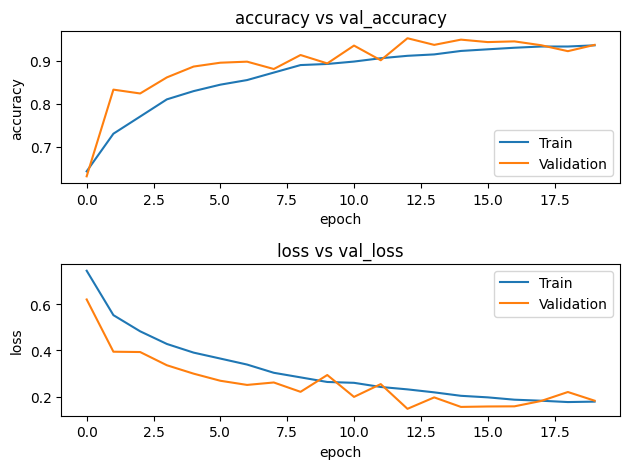

In [18]:
# Let's visualize the train/validation loss and accuracy wrt epochs

import matplotlib.pyplot as plt 
def plot(history):
    plt.figure(1) 
     # summarize history for accuracy  
 
    plt.subplot(211)  
    plt.plot(history.history['accuracy'])  
    plt.plot(history.history['val_accuracy'])  
    plt.title('accuracy vs val_accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('epoch')  
    plt.legend(['Train', 'Validation'], loc='lower right')  
 
     # summarize history for loss  
 
    plt.subplot(212)  
    plt.plot(history.history['loss'])  
    plt.plot(history.history['val_loss'])  
    plt.title('loss vs val_loss')  
    plt.ylabel('loss')  
    plt.xlabel('epoch')  
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.tight_layout()
    plt.show()
 
# call plot function with the 'result' parameter 
 
plot(history)

### **Prediction**
>Finally, let us test our model against more random samples from the test data !

39/39 [==============================] - 4s 106ms/step


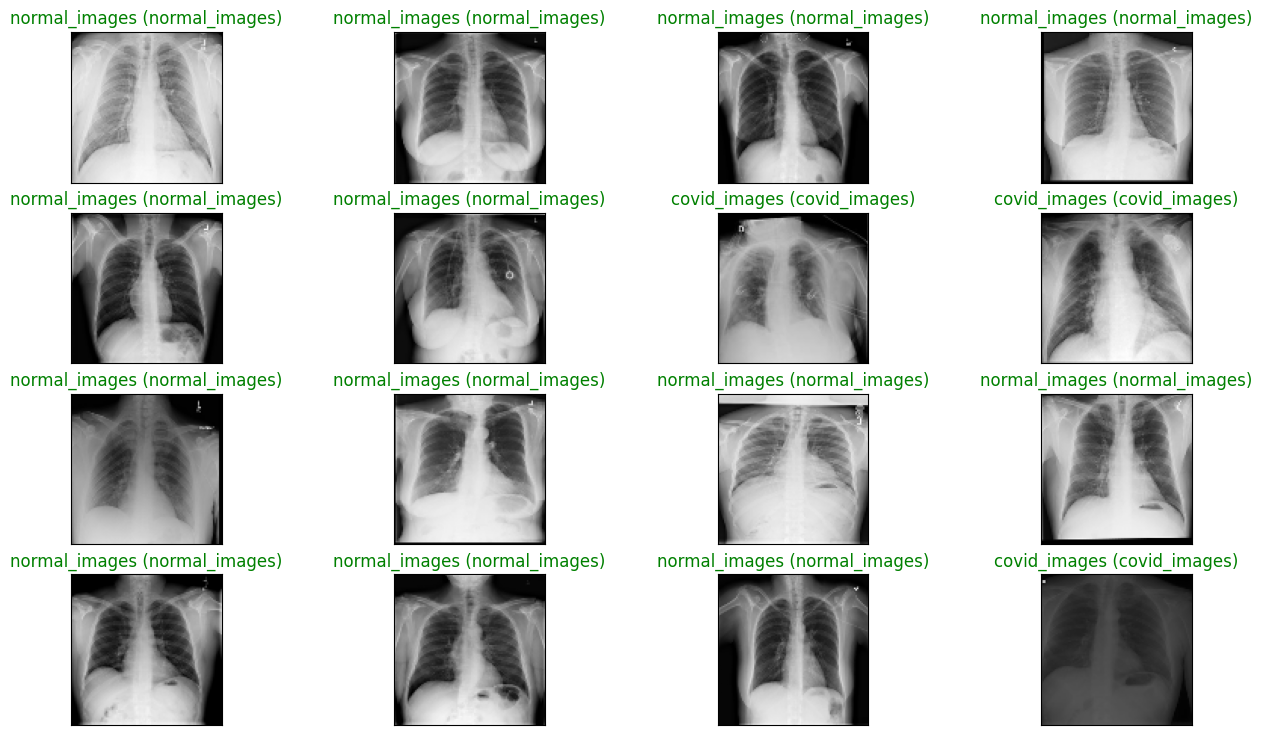

In [19]:
# Let's visualize some random test prediction.
def visualize_pred(y_pred):
# plot a random sample of test images, their predicted labels, and ground truth
    fig = plt.figure(figsize=(16, 9))
    for i, idx in enumerate(np.random.choice(X_test.shape[0], size=16, replace=False)):
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(X_test[idx]))
        pred_idx = np.argmax(y_pred[idx])
        true_idx = np.argmax(y_test[idx])
        ax.set_title("{} ({})".format(labels[pred_idx], labels[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))

visualize_pred(model.predict(X_test))

### Confusion Matrix

39/39 [==============================] - 4s 114ms/step


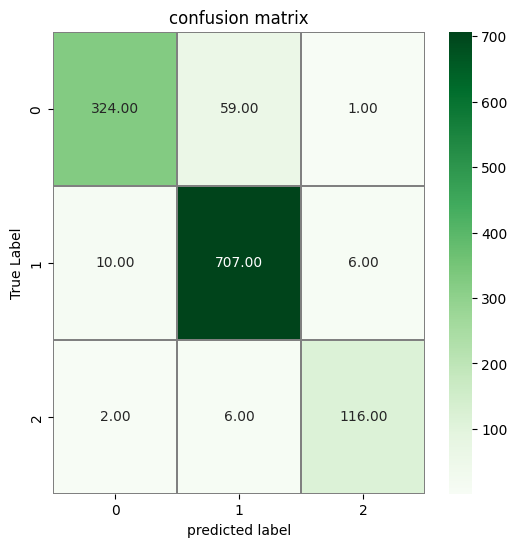

In [20]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1)
Y_true = np.argmax(y_test,axis = 1)
confusion_mtx = confusion_matrix(Y_true,Y_pred_classes)
f,ax = plt.subplots(figsize = (6,6))
sns.heatmap(confusion_mtx,annot=True,linewidths = 0.01,cmap="Greens",
            linecolor = "gray",fmt = ".2f",ax=ax
            )
plt.xlabel("predicted label")
plt.ylabel("True Label")
plt.title("confusion matrix")
plt.show()

**Few Take aways:**
- The easiest to detect is **Covid-19**, i.e. if you are infected then you are really infected
- It is clear that the model can sometimes deceive in stating that a person is not infected but it could be. Anyways, we need the expertise to explain this kind of stuff, especially when it comes to medicine. **Just we must not forget that we do not have enough images for Covid-19**.

- Our confusion matrix indicates that there are disturbing errors. which is Great!.

> You can check the classification report below for more information !

In [48]:
print(classification_report(y_test.argmax(axis=1),Y_pred_classes,  target_names= labels))

               precision    recall  f1-score   support

 covid_images       0.80      0.78      0.79       358
normal_images       0.89      0.91      0.90       748
 viral_images       0.94      0.90      0.92       125

     accuracy                           0.87      1231
    macro avg       0.88      0.86      0.87      1231
 weighted avg       0.87      0.87      0.87      1231



### Loading the model
> Here we're gonna load our best model trained befor, then make some predictions with it !

In [49]:
my_model=keras.models.load_model("C:/Users/HP/Downloads/COVID-19-Detection-From-X-Ray-master/COVID-19-Detection-From-X-Ray-master/Covid_cnn.h5")

39/39 [==============================] - 4s 99ms/step


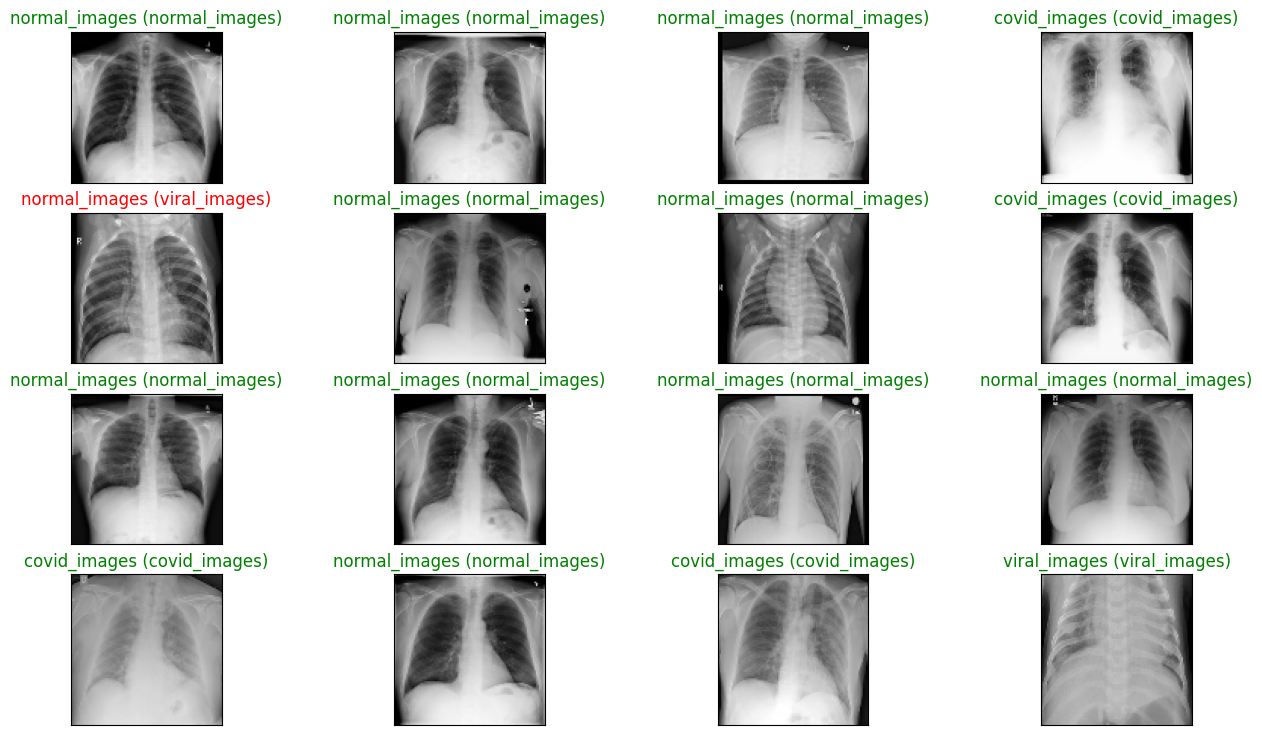

In [50]:
# Let's visualize some random test prediction.
def visualize_pred(y_pred):
# plot a random sample of test images, their predicted labels, and ground truth
    fig = plt.figure(figsize=(16, 9))
    for i, idx in enumerate(np.random.choice(X_test.shape[0], size=16, replace=False)):
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(X_test[idx]))
        pred_idx = np.argmax(y_pred[idx])
        true_idx = np.argmax(y_test[idx])
        ax.set_title("{} ({})".format(labels[pred_idx], labels[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))

visualize_pred(my_model.predict(X_test))